# Nautilus Port

Starting point: https://github.com/anitagraser/Nautilus

In [1]:
import os
import time

import numpy as np
import pandas as pd
import geopandas as gpd

from tqdm.auto import tqdm
from torch.utils.data import DataLoader

import dataset as ds
import st_toolkit as stt



/home/grasera/anaconda3/envs/nautilus/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

### Load AIS

In [2]:
CFG_ROOT = r"/mnt/c/Users/GraserA/Documents/Zenodo/Integrated Maritime"
VESSEL_ID_NAME, SPEED_NAME, COURSE_NAME, TIMESTAMP_NAME, TIMESTAMP_UNIT, COORDS_NAMES, COORDS_CRS = 'sourcemmsi', 'speedoverground', 'courseoverground', 't', 's', ['lon', 'lat'], 4326

df = pd.read_csv(os.path.join(CFG_ROOT, 'nari_dynamic.csv')) 
print(f'[Raw Dataset] Dataset AIS Positions: {len(df)}')

[Raw Dataset] Dataset AIS Positions: 19035630


In [3]:
df_static = pd.read_csv(os.path.join(CFG_ROOT, 'nari_static.csv'))
df_static = df_static.sort_values(
    TIMESTAMP_NAME
).dropna(
    subset=['shiptype']
).drop_duplicates(
    subset=[VESSEL_ID_NAME], keep='last'
)[[VESSEL_ID_NAME, 'shiptype']]
df_static

/tmp/ipykernel_20010/2905350653.py:1: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_static = pd.read_csv(os.path.join(CFG_ROOT, 'nari_static.csv'))


,sourcemmsi,shiptype
250,636016115,82.0
593,636013974,70.0
666,211366340,52.0
686,567468000,70.0
814,376783000,70.0
...,...,...
1078486,227315190,30.0
882872,227142200,30.0
882873,234056000,0.0
1078487,227362110,37.0


### Filter AIS based on MID whitelist

In [4]:
mmsi_mid = pd.read_csv('./mmsi_mid_whitelist.csv')
df = df.loc[
    df[VESSEL_ID_NAME].astype(str).str.zfill(9).str[:3].isin(
        mmsi_mid.MID.astype(str)
    )
].copy()
print(f'[Invalid MMSIs] Dataset AIS Positions: {len(df)}')

[Invalid MMSIs] Dataset AIS Positions: 18657808


In [5]:
df.loc[:, f'timestamp_datetime'] = pd.to_datetime(df.loc[:, TIMESTAMP_NAME], unit=TIMESTAMP_UNIT)
df.loc[:, f'timestamp_sec'] = df.timestamp_datetime.astype(int) // 10**9

### Subsample Trajectories \w $\Delta t_{min}$

In [6]:
def subsample_trajectory(traj, time_name, min_dt_sec=10):
    # Based on: https://stackoverflow.com/a/56904899
    sumlm = np.frompyfunc(lambda a,b: a+b if a < min_dt_sec else b, 2, 1)

    traj_dt = traj[time_name].diff()
    traj_dt_sumlm = sumlm.accumulate(traj_dt, dtype=int)

    return traj.drop(traj_dt_sumlm.loc[traj_dt_sumlm < min_dt_sec].index)

In [7]:
tqdm.pandas()
df_clean = df.sort_values('timestamp_sec', kind='mergesort').groupby(VESSEL_ID_NAME).progress_apply(
    lambda l: subsample_trajectory(
        l.copy(), 'timestamp_sec'
    )
).reset_index(level=0, drop=True)
print(f'[Subsampling] Dataset AIS Positions: {len(df_clean)}')
print(f'{df_clean.sort_values("timestamp_sec").groupby(VESSEL_ID_NAME)["timestamp_sec"].diff().describe().astype(str)=}')

  0%|          | 0/5040 [00:00<?, ?it/s]

/home/grasera/anaconda3/envs/mobispaces-copy/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in accumulate
  result = getattr(ufunc, method)(*inputs, **kwargs)


[Subsampling] Dataset AIS Positions: 12531947
df_clean.sort_values("timestamp_sec").groupby(VESSEL_ID_NAME)["timestamp_sec"].diff().describe().astype(str)=count           12526907.0
mean     1397.994333238045
std      76551.41621208492
min                   10.0
25%                   10.0
50%                   13.0
75%                   20.0
max             14841285.0
Name: timestamp_sec, dtype: object


### Drop trajectories \w less than $Points_{min}$ locations

In [8]:
min_pts = 20
vessels_points = df_clean[VESSEL_ID_NAME].value_counts() 

df_clean = df_clean.loc[
    df_clean[VESSEL_ID_NAME].isin(
        vessels_points.loc[vessels_points > min_pts].index
    )
].copy()
print(f'[Trajectory Pruning] Dataset AIS Positions: {len(df_clean)}')

[Trajectory Pruning] Dataset AIS Positions: 12517873


### Re-calculate Speed and Course over Ground

In [9]:
NJOBS=50

df_clean = gpd.GeoDataFrame(df_clean, geometry=gpd.points_from_xy(df_clean[COORDS_NAMES[0]], df_clean[COORDS_NAMES[1]]), crs=COORDS_CRS)
df_clean.sort_index(inplace=True)


In [10]:
df_clean = stt.add_speed(
    df_clean, o_id=[VESSEL_ID_NAME,], ts='timestamp_sec', speed=SPEED_NAME, geometry=df_clean.geometry.name, n_jobs=NJOBS
)


Scaling <function add_speed.<locals>.<lambda> at 0x7f2da77285e0> to 50 CPUs


100%|██████████| 2177/2177 [03:12<00:00, 11.28it/s]


In [11]:
df_clean = stt.add_course(
    df_clean, o_id=[VESSEL_ID_NAME,], ts='timestamp_sec', course=COURSE_NAME, geometry=df_clean.geometry.name, n_jobs=NJOBS
)

Scaling <function add_course.<locals>.<lambda> at 0x7f2e49067e20> to 50 CPUs


100%|██████████| 2177/2177 [03:05<00:00, 11.75it/s]


### Drop Speed Outliers (points \w speed outside the range [$Speed_{min}$, $Speed_{max}$])

In [12]:
MIN_SPEED, MAX_SPEED = 1, 50

df_clean.drop(
    df_clean.loc[~df_clean[SPEED_NAME].between(MIN_SPEED, MAX_SPEED, inclusive='both')].index,
    axis=0,
    inplace=True
)
print(f'[Speed Outliers] Dataset AIS Positions: {len(df_clean)}')
print(f'{df_clean[SPEED_NAME].describe().round(5).astype(str)=}')

df_clean_coords_meters = stt.applyParallel(
    df_clean.sort_values('timestamp_sec').groupby(VESSEL_ID_NAME),
    lambda traj: traj.to_crs(3857)[traj.geometry.name].apply(
        lambda point: pd.Series(stt.shapely_coords_numpy(point), index=['lon_3857', 'lat_3857'])
    ),
    n_jobs=NJOBS,
    dynamic_ncols=True
).reset_index(level=0, drop=True)
df_clean.loc[:, ['lon_3857', 'lat_3857']] = df_clean_coords_meters


[Speed Outliers] Dataset AIS Positions: 4599006
df_clean[SPEED_NAME].describe().round(5).astype(str)=count    4599006.0
mean       8.93507
std        4.92962
min        1.00001
25%        5.44683
50%        8.56766
75%       11.43565
max       49.98598
Name: speedoverground, dtype: object
Scaling <function <lambda> at 0x7f2da77284c0> to 50 CPUs


100%|██████████| 2158/2158 [01:33<00:00, 23.18it/s]


### Temporal Segmentation

In [13]:
CFG_EPS = 1e-9
MAX_DT = 1800

kwargs = dict(
    col_name = 'timestamp_sec',
    threshold = MAX_DT + CFG_EPS,
    min_pts = min_pts,
    output_name = 'temp_traj_nr'
)

tqdm.pandas()
gdf_seg = df_clean.sort_values('timestamp_sec').groupby([VESSEL_ID_NAME,], group_keys=False).progress_apply(
    lambda l: stt.temporal_segmentation(
        l.copy(), **kwargs
    )
)
print(f'[Temporal Segmentation] Dataset AIS Positions: {len(gdf_seg)}')

  0%|          | 0/2158 [00:00<?, ?it/s]

[Temporal Segmentation] Dataset AIS Positions: 4408217


In [14]:
gdf_seg.loc[:, 'traj_nr'] = gdf_seg.groupby([VESSEL_ID_NAME, 'temp_traj_nr']).ngroup()
gdf_seg.groupby([VESSEL_ID_NAME, 'traj_nr']).apply(len).sort_values()

sourcemmsi  traj_nr
235084729   12001         20
227008170   1813          20
250002286   12870         20
227008170   1816          20
224057000   308           20
                       ...  
228762000   11402       8669
228109000   9650        9378
            9661        9521
228186700   10286       9600
228394000   11345      13638
Length: 14418, dtype: int64

### Save Results

In [15]:
gdf_seg.drop(
    ['geometry'], axis=1
).rename(
    {'timestamp_datetime':'timestamp', 'traj_nr':'id'}, axis=1
).sort_values('timestamp_sec').to_csv(
    os.path.join('dataset_trajectories_preprocessed.fixed.csv'),
    index=True, 
    header=True
)

## Training

In [3]:
mmsi_mid = pd.read_csv('./mmsi_mid_whitelist.csv')
trajectories = pd.read_csv(f'dataset_trajectories_preprocessed.fixed.csv', parse_dates=['timestamp'])
print(f'[Loaded] Dataset AIS Positions: {len(trajectories)}')
VESSEL_NAME, SPEED_NAME, COURSE_NAME, TIME_NAME, TYPE_NAME = 'sourcemmsi', 'speedoverground', 'courseoverground', 't', 'shiptype'

trajectories_mmsis = trajectories[VESSEL_NAME].unique()
valid_mmsis = [mmsi for mmsi in trajectories_mmsis if mmsi//10**6 in mmsi_mid.MID.values]
trajectories = trajectories.loc[trajectories[VESSEL_NAME].isin(valid_mmsis)].copy()
print(f'[Invalid MIDs] Dataset AIS Positions: {len(trajectories)}')

[Loaded] Dataset AIS Positions: 4408217
[Invalid MIDs] Dataset AIS Positions: 4408217


In [ ]:
trajectories = gpd.GeoDataFrame(trajectories, crs=4326, geometry=gpd.points_from_xy(trajectories['lon'], trajectories['lat']))


### Temporal train/dev/test split

50/25/25 (e.g., 3mos, ~1.5mos will be used for train and ~0.75mos will be used for validation and testing, respectively)

In [4]:
trajectories_dates = trajectories.timestamp.dt.date.sort_values().unique()
train_dates, dev_dates, test_dates = ds.timeseries_train_test_split(trajectories_dates, dev_size=0.25, test_size=0.25, shuffle=False)

print(
    f'Train @{(min(trajectories_dates[train_dates]), max(trajectories_dates[train_dates]))=};'+\
    f'\nDev @{(min(trajectories_dates[dev_dates]), max(trajectories_dates[dev_dates]))=};'+\
    f'\nTest @{(min(trajectories_dates[test_dates]), max(trajectories_dates[test_dates]))=}'
)

Train @(min(trajectories_dates[train_dates]), max(trajectories_dates[train_dates]))=(datetime.date(2015, 9, 30), datetime.date(2015, 12, 30));
Dev @(min(trajectories_dates[dev_dates]), max(trajectories_dates[dev_dates]))=(datetime.date(2015, 12, 31), datetime.date(2016, 2, 14));
Test @(min(trajectories_dates[test_dates]), max(trajectories_dates[test_dates]))=(datetime.date(2016, 2, 15), datetime.date(2016, 3, 31))


In [5]:
CRS=2154

trajectories.loc[trajectories['timestamp'].dt.date.isin(trajectories_dates[train_dates]), 'dataset_tr1_val2_test3'] = 1
trajectories.loc[trajectories['timestamp'].dt.date.isin(trajectories_dates[dev_dates]), 'dataset_tr1_val2_test3'] = 2
trajectories.loc[trajectories['timestamp'].dt.date.isin(trajectories_dates[test_dates]), 'dataset_tr1_val2_test3'] = 3

params = dict(
    time_name=TIME_NAME, 
    speed_name=SPEED_NAME, 
    course_name=COURSE_NAME, 
    crs=CRS, 
    min_pts=20
)

print(f"Sanity Check #1;\n\t{trajectories.groupby([VESSEL_NAME, 'id', 'dataset_tr1_val2_test3'])['timestamp'].is_monotonic_increasing.all()=}")


Sanity Check #1;
	trajectories.groupby([VESSEL_NAME, 'id', 'dataset_tr1_val2_test3'])['timestamp'].is_monotonic_increasing.all()=True


### Create VRF training dataset

In [6]:
def create_delta_dataset(segment, time_name, speed_name, course_name, crs=3857, min_pts=22):
    """
    Create delta series
    """
    if len(segment) < min_pts:
        return None

    segment.sort_values(time_name, inplace=True)
    
    delta_curr = segment.to_crs(crs)[segment.geometry.name].apply(lambda l: pd.Series(stt.shapely_coords_numpy(l), index=['dlon', 'dlat'])).diff()
    delta_curr_feats = segment[[speed_name, course_name]].diff().rename({speed_name:'dspeed_curr', course_name:'dcourse_curr'}, axis=1)
    delta_next = delta_curr.shift(-1)
    delta_tau  = pd.merge(
        segment[time_name].diff().rename('dt_curr'),
        segment[time_name].diff().shift(-1).rename('dt_next'),
        right_index=True, 
        left_index=True
    )
    
    return delta_curr.join(delta_curr_feats).join(delta_tau).join(delta_next, lsuffix='_curr', rsuffix='_next').dropna(subset=['dt_curr', 'dt_next']).fillna(method='bfill')


In [8]:
NJOBS=50
traj_delta = stt.applyParallel(
    trajectories.groupby([VESSEL_NAME, 'id', 'dataset_tr1_val2_test3'], group_keys=True), 
    lambda l: create_delta_dataset(l, **params),
    n_jobs=NJOBS
)

Scaling <function <lambda> at 0x7fab2515e290> to 50 CPUs


100%|██████████| 14421/14421 [02:08<00:00, 111.88it/s]


In [9]:
def traj_windowing(
    segment, 
    length_max=1024, 
    length_min=20,
    stride=512, 
    input_feats=['dlon_curr', 'dlat_curr', 'dt_curr', 'dt_next'], 
    output_feats=['dlon_next', 'dlat_next'], 
):
    """
    Create constant-length windows for ML model training
    """
    traj_inputs, traj_labels = [], []
    
    output_feats_idx = [segment.columns.get_loc(output_feat) for output_feat in output_feats]
        
    for ptr_curr in range(0, len(segment), stride):
        segment_window = segment.iloc[ptr_curr:ptr_curr+length_max].copy()     

        if len(segment_window) < length_min:
            break

        traj_inputs.append(segment_window[input_feats].values)
        traj_labels.append(segment_window.iloc[-1, output_feats_idx].values)
    
    return pd.Series([traj_inputs, traj_labels], index=['samples', 'labels'])

In [10]:
LENGTH = 32 
STRIDE = 16
DSPEED = True
DCOURSE = True

windowing_params = dict(
    length_min=18, 
    length_max=LENGTH, 
    stride=STRIDE,
    input_feats=[
        'dlon_curr', 
        'dlat_curr', 
        *(['dspeed_curr',] if DSPEED else []),
        *(['dcourse_curr',] if DCOURSE else []),
        'dt_curr',
        'dt_next'
    ]
)
print(f'{windowing_params["input_feats"]=}')

traj_delta_windows = stt.applyParallel(
    traj_delta.reset_index().groupby([VESSEL_NAME, 'id', 'dataset_tr1_val2_test3']),
    lambda l: traj_windowing(l, **windowing_params),
    n_jobs=NJOBS
).reset_index(level=-1)\
    .pivot(columns=['level_3'])\
    .rename_axis([None, None], axis=1)\
    .sort_index(axis=1, ascending=False)

windowing_params["input_feats"]=['dlon_curr', 'dlat_curr', 'dspeed_curr', 'dcourse_curr', 'dt_curr', 'dt_next']
Scaling <function <lambda> at 0x7fac2d17a3b0> to 50 CPUs


100%|██████████| 14421/14421 [00:23<00:00, 624.05it/s]


In [11]:
traj_delta_windows.columns = traj_delta_windows.columns.droplevel(0)
traj_delta_windows = traj_delta_windows.explode(['samples', 'labels'])

traj_delta_windows.to_pickle(
    f'window_{windowing_params["length_max"]}_stride_{windowing_params["stride"]}_crs_{CRS}_'+\
    f'{"dspeed" if DSPEED else ""}_'+\
    f'{"dcourse" if DCOURSE else ""}.traj_delta_windows.pickle'
)

### Split trajectories train/dev/test sets

In [13]:
MAX_DT = 1800
bins = np.arange(0, MAX_DT  +1, 300)
look_discrete = pd.cut(traj_delta_windows.samples.apply(lambda l: l[-1, -1]), bins=bins).rename('labels')

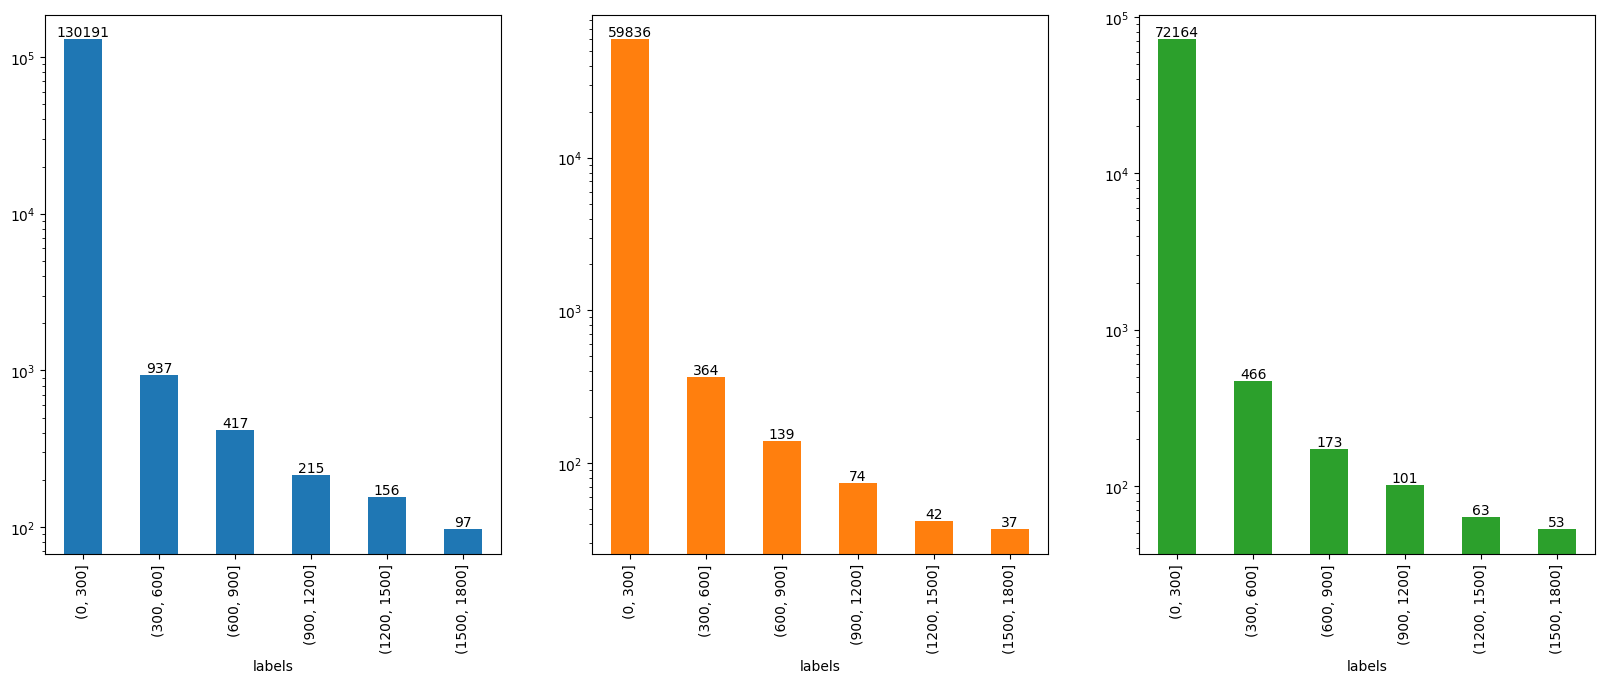

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20, 7))
# pdb.set_trace()
look_discrete.xs(1, level=2).value_counts(sort=False).plot.bar(ax=ax[0], color='tab:blue')
look_discrete.xs(2, level=2).value_counts(sort=False).plot.bar(ax=ax[1], color='tab:orange')
look_discrete.xs(3, level=2).value_counts(sort=False).plot.bar(ax=ax[2], color='tab:green')

[ax_i.set_yscale('log') for ax_i in ax];
[ax_i.bar_label(ax_i.containers[0]) for ax_i in ax];
plt.savefig(
    f'window_{windowing_params["length_max"]}_stride_{windowing_params["stride"]}_crs_{CRS}_'+\
    f'{"dspeed" if DSPEED else ""}_'+\
    f'{"dcourse" if DCOURSE else ""}_'+\
    f'.pdf',
    dpi=300, 
    bbox_inches='tight'
)

### Create unified train/dev/test dataset(s)

In [15]:
train_delta_windows = traj_delta_windows.xs(1, level=2).copy()
dev_delta_windows = traj_delta_windows.xs(2, level=2).copy()
test_delta_windows = traj_delta_windows.xs(3, level=2).copy()

### Create kinematic features' temporal sequence (i.e. training dataset)

In [16]:
BS=1

train_dataset = ds.VRFDataset(train_delta_windows)
dev_dataset, test_dataset = ds.VRFDataset(dev_delta_windows, scaler=train_dataset.scaler),\
                            ds.VRFDataset(test_delta_windows, scaler=train_dataset.scaler)

train_loader, dev_loader, test_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, collate_fn=train_dataset.pad_collate),\
                                        DataLoader(dev_dataset,   batch_size=BS, shuffle=False, collate_fn=dev_dataset.pad_collate),\
                                        DataLoader(test_dataset,  batch_size=BS, shuffle=False, collate_fn=test_dataset.pad_collate)

In [17]:
import torch

GPUID=0

device = torch.device(f'cuda:{GPUID}') if torch.cuda.is_available() else torch.device('cpu')

model_params = dict({},
    input_size=len(windowing_params['input_feats']),
    scale=dict(
        sigma=torch.Tensor(train_dataset.scaler.scale_[:2]), 
        mu=torch.Tensor(train_dataset.scaler.mean_[:2])
    ),
    bidirectional=True,
    num_layers=1,
    hidden_size=350,
    fc_layers=[150,]
)

In [18]:
import models as ml 
import train as tr 

model = ml.VesselRouteForecasting(**model_params)
model.to(device)

print(model)
print(f'{device=}')

criterion = tr.RMSELoss(eps=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

VesselRouteForecasting(
  (rnn_cell): LSTM(6, 350, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=700, out_features=150, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=150, out_features=2, bias=True)
  )
)
device=device(type='cuda', index=0)
self.eps=0.0001


In [21]:
model_name_base =   f'nautilus.epoch{0}.pth'
save_path_epoch = model_name_base
save_path_best = model_name_base.format('best')
print(save_path_epoch)  

nautilus.epoch0.pth


In [22]:
PATIENCE = 10

evaluate_fun_params = dict(
    bins=np.arange(0, MAX_DT+1, 300)
)

early_stop_params = dict(
    patience=PATIENCE,
    save_best=True,
    path=save_path_best
)

save_current_params = dict(
    path=save_path_epoch
)

tr.train_model(
    model, device, criterion, optimizer, 3, # originally: 100 rounds
    train_loader, dev_loader, early_stop=True, save_current=True, 
    evaluate_fun=tr.vrf_evaluate_model_singlehead, evaluate_fun_params=evaluate_fun_params,
    early_stop_params=early_stop_params, save_current_params=save_current_params
)

Loss Decreased (inf -> 17.76585). Saving Model... Done!
Epoch #1/3 | Train Loss: 20.38124 | Validation Loss: 17.76585 | Time Elapsed: 1927.09809


Loss: 17.76585 |  Accuracy: 25.12469 | 15.07267; 461.91650; 942.52179; 1553.51599; 2402.90112; 2781.72656 m


Loss Decreased (17.76585 -> 14.99800). Saving Model... Done!
Epoch #2/3 | Train Loss: 18.44233 | Validation Loss: 14.99800 | Time Elapsed: 1937.82269


Loss Decreased (14.99800 -> 14.80614). Saving Model... Done!
Epoch #3/3 | Train Loss: 17.26741 | Validation Loss: 14.80614 | Time Elapsed: 1919.02956


([array(20.381235, dtype=float32),
  array(18.442326, dtype=float32),
  array(17.267412, dtype=float32)],
 [array(17.76585, dtype=float32),
  array(14.998001, dtype=float32),
  array(14.806138, dtype=float32)])

## Load best model and test its accuracy on the test set

In [23]:
checkpoint = torch.load(save_path_best)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

tr.vrf_evaluate_model_singlehead(model, device, criterion, test_loader, desc='ADE @ Test Set...', **evaluate_fun_params)

Loss: 14.71818 |  Accuracy: 20.81462 | 13.61749; 349.00308; 668.95441; 948.02118; 1284.83435; 1549.65906 m


(tensor(14.7182), 20.81462)